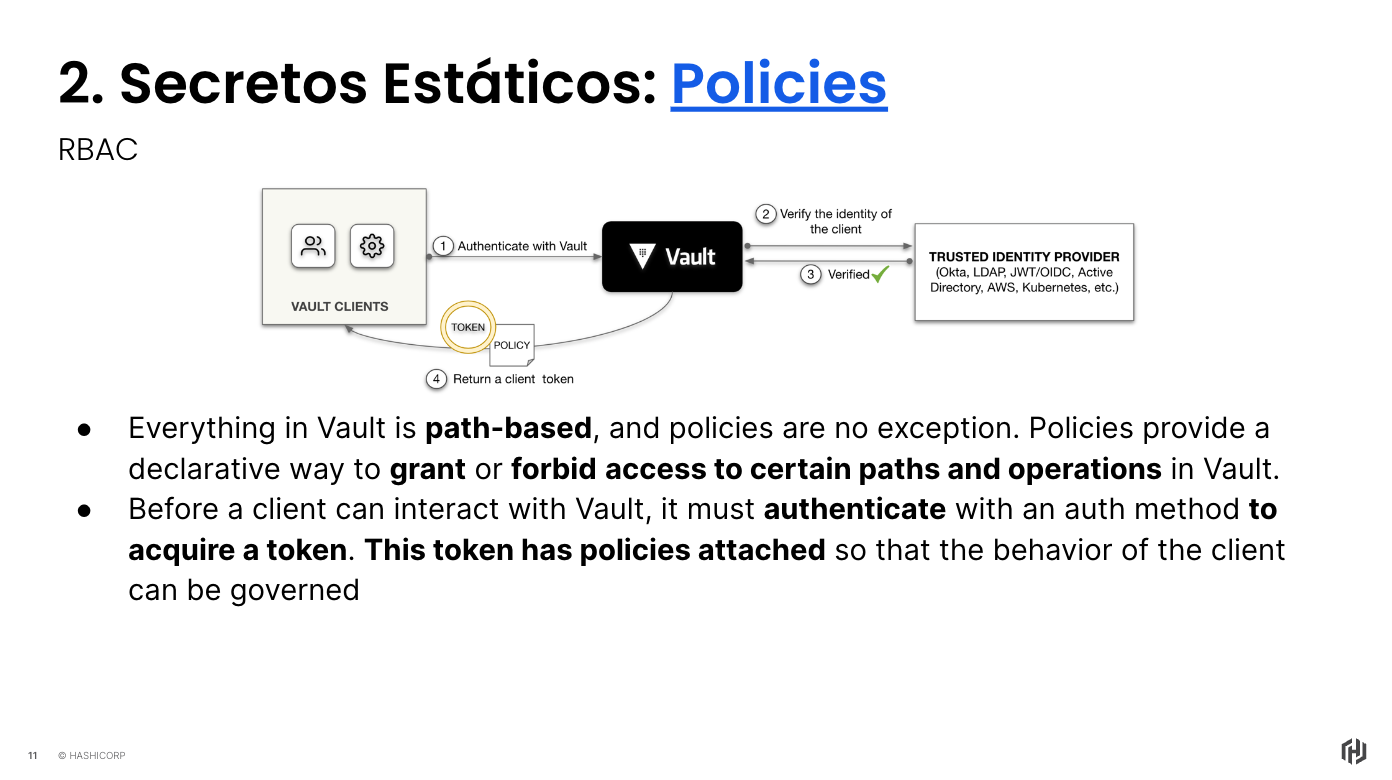

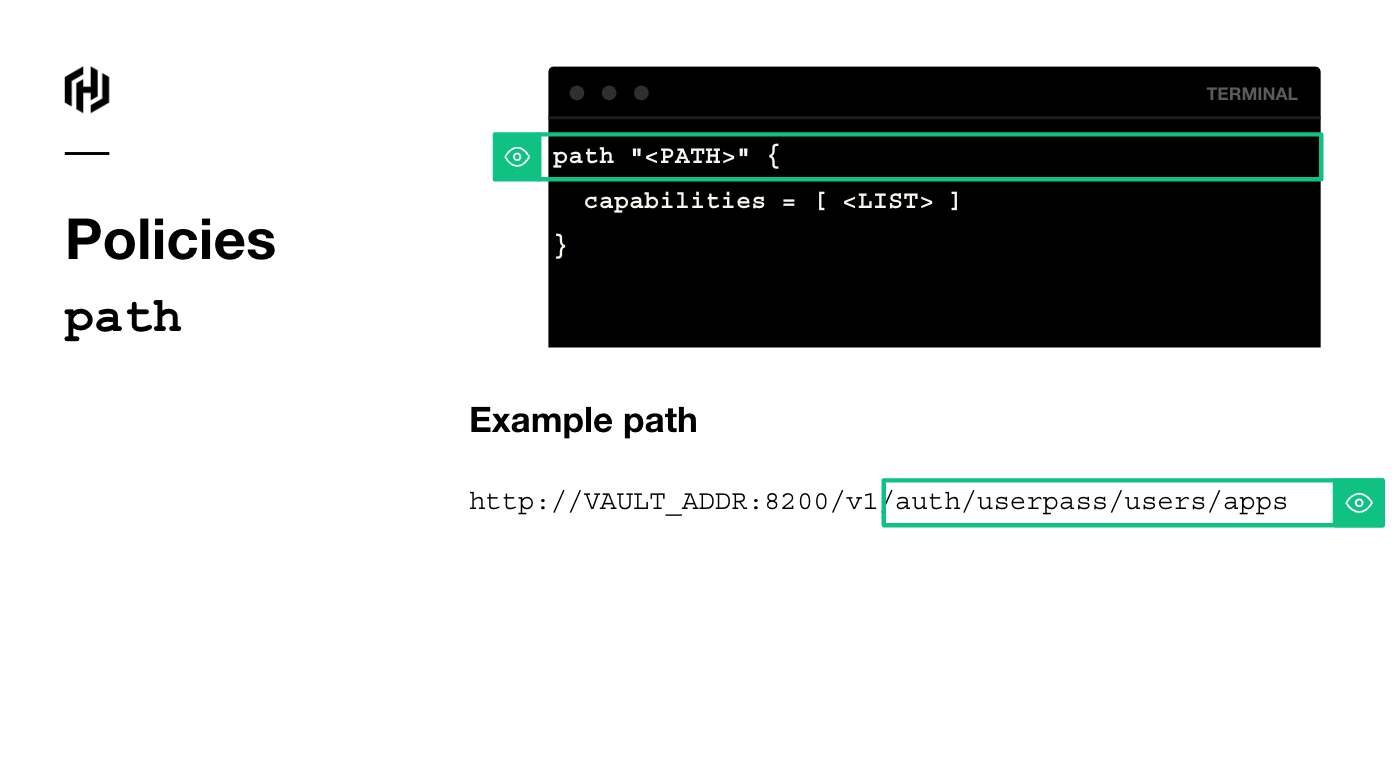

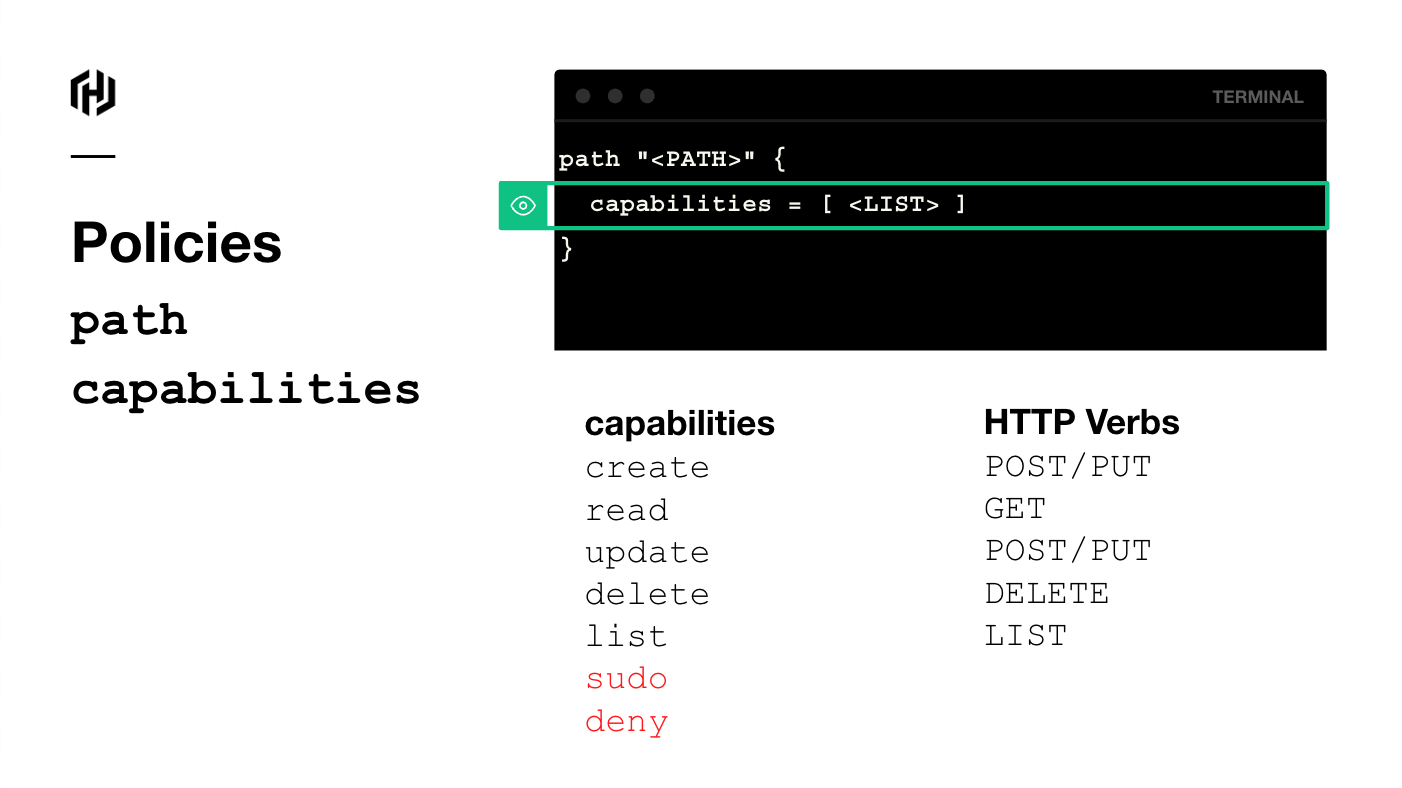

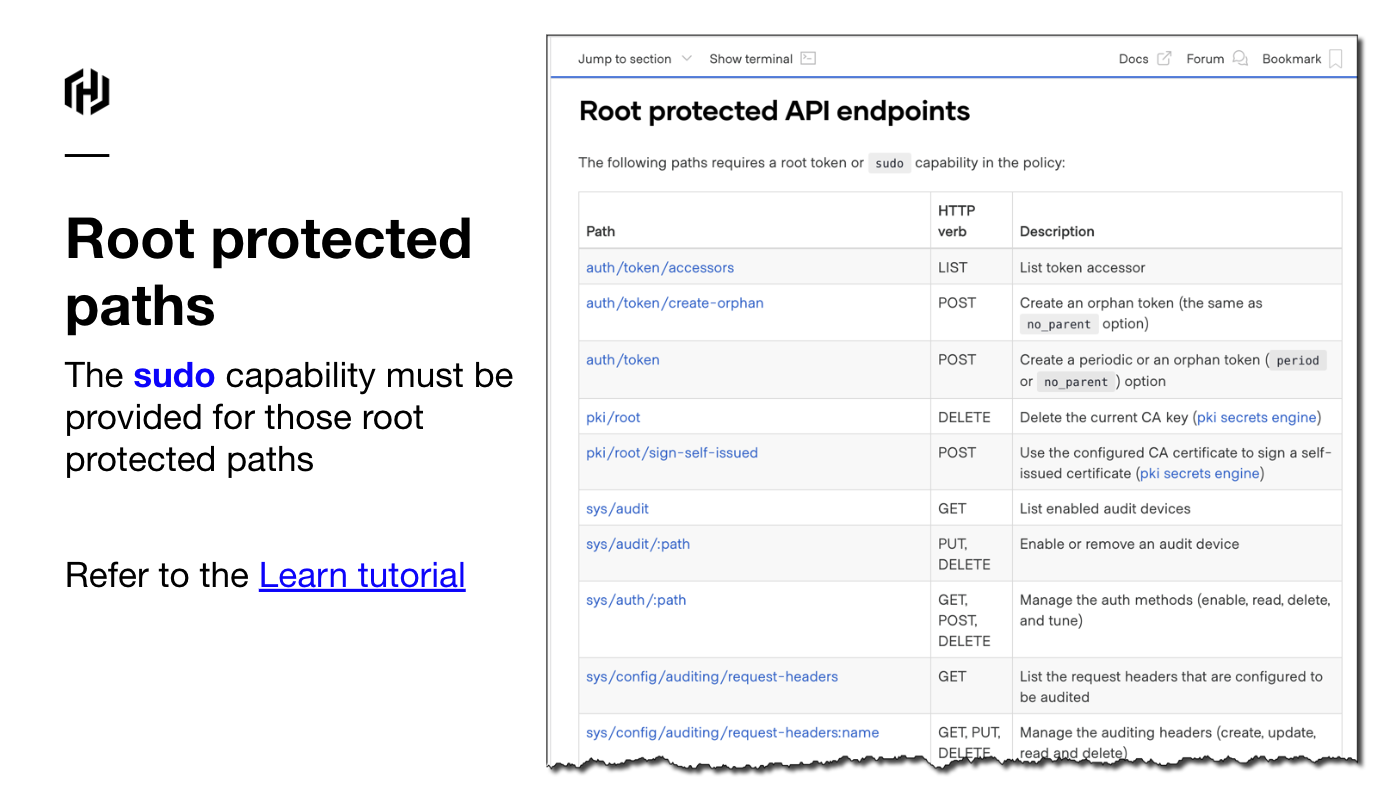

In [ ]:
%env  WORKDIR=/tmp/vault

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv("/tmp/vault/config.env")

VAULT_TOKEN = os.getenv('VAULT_TOKEN')
VAULT_ADDR = os.getenv('VAULT_ADDR')
VAULT_CACERT = os.getenv('VAULT_CACERT')

In [ ]:
%%bash
kubectl apply -f openldap_deployment.yml

In [ ]:
! kubectl get pods -n vault

In [ ]:
%%bash
vault auth enable ldap

In [ ]:
! vault secrets list

In [ ]:
%%bash
vault write auth/ldap/config \
    binddn="cn=admin,dc=learn,dc=example" \
    bindpass="2LearnVault" \
    url="ldap://openldap:389" \
    userdn="ou=users,dc=learn,dc=example" \
    userattr="cn" \
    userfilter="({{.UserAttr}}={{.Username}})" \
    groupdn="dc=learn,dc=example"\
    groupfilter="(&(objectClass=person)(cn={{.Username}}))" \
    groupattr="memberOf"\
    insecure_tls=true

In [ ]:
%%bash
vault write auth/ldap/groups/dev policies=dev
vault write auth/ldap/groups/ops policies=ops

In [ ]:
%%bash

cat >  $WORKDIR/dev_policy.hcl <<EOF
/*
path "secret/data/*" {
  capabilities = ["list"]
}
path "secret/metadata/*" {
  capabilities = [ "list"]
}
*/
path "secret/data/bu/org/cert" {
  capabilities = ["list"]
}

path "secret/data/bu/org/cert/*" {
  capabilities = ["list"]
}

path "secret/metadata/bu/org/cert" {
  capabilities = ["list", "read"]
}

path "secret/metadata/bu/org/cert/*" {
  capabilities = ["list", "read"]
}

path "secret/data/bu/org/cert/app/*" {
  capabilities = ["list", "read"]
}

path "secret/metadata/bu/org/cert/app/*" {
  capabilities = ["list", "read"]
}

/*
path "secret/data/dev" {
  capabilities = ["list"]
}
# Can create secret on secret/dev only
path "secret/data/dev/*" {
  capabilities = ["create", "update", "read", "list"]
}
path "secret/metadata/dev/*" {
  capabilities = ["read", "create", "update", "list"]
}
 
# List enabled secrets engine
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}
*/

EOF

#---

cat >  $WORKDIR/ops_policy.hcl <<EOF

path "*" {
  capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

EOF

vault policy write dev $WORKDIR/dev_policy.hcl
vault policy write ops $WORKDIR/ops_policy.hcl


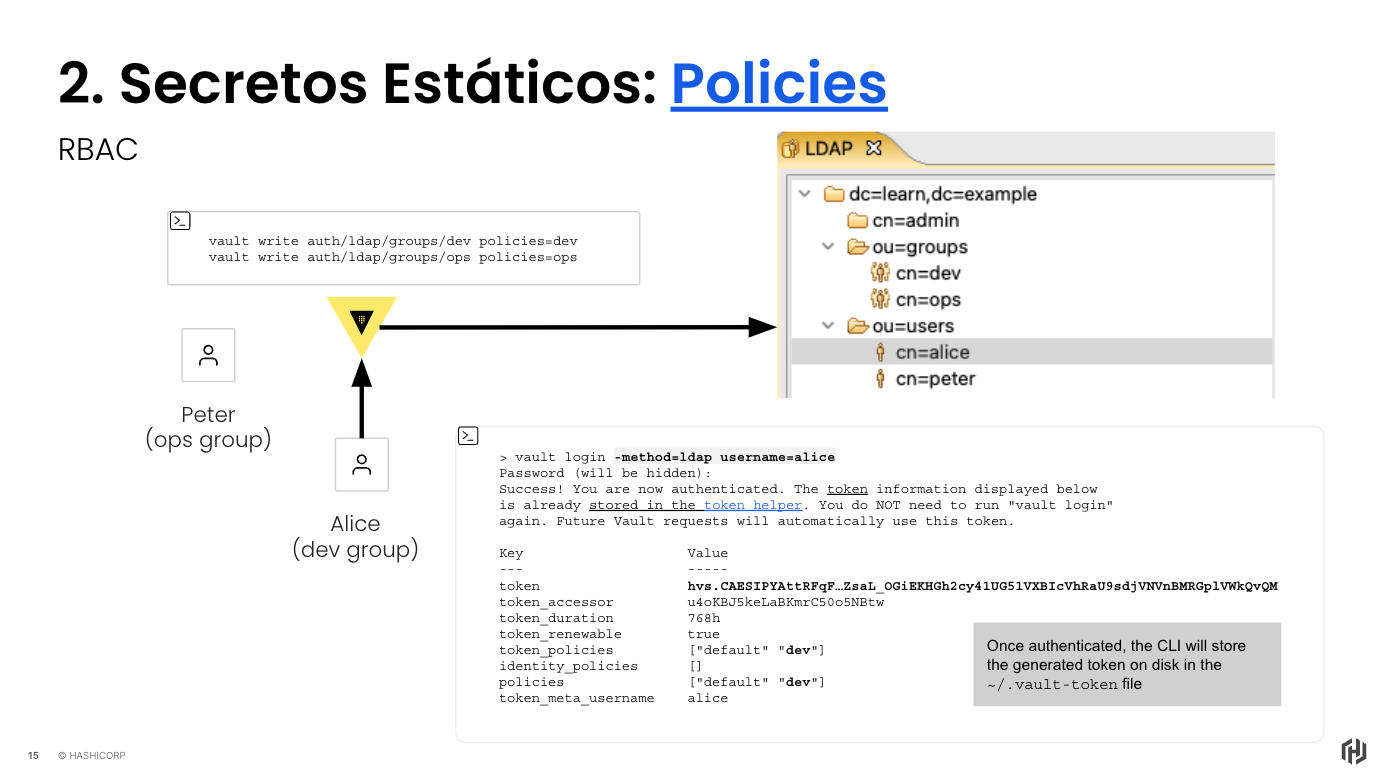